In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/data_1min_p.rar" "/content/content/data_1min/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/data_1min_p.rar

Creating    /content/content                                          OK
Creating    /content/content/data_1min                                OK
Extracting  /content/content/data_1min/TONUSDT.pickle                      0%  1%  OK 
Extracting  /content/content/data_1min/ETHUSDT.pickle                      2%  3%  OK 
Extracting  /content/content/data_1min/EIGENUSDT.pickle                    3%  4%  OK 
Extracting  /content/content/data_1min/ARBUSDT.pickle                      5%  OK 
Extracting  /content/content/data_1min/PENGUUSDT.pickle                    6%  7%  OK 
Extracting  /content/content/data_1min/ENAUSDT.pickle                      8%  OK 
Extracting  /content/content/data_1min/1000BONKUSDT.pickle                 9% 10%  OK 
Extracting  /content/content/data_1min

Loading Embeded news based on Finbert

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Loading OHLCV of multi stocks

In [4]:
import os
# data_crypto_path = '/content/content2/'
# list_crypto = [x[5:-4] for x in os.listdir(data_crypto_path) if 'data_' in x and 'FORMUSDT' not in x]

data_crypto_path = '/content/content/data_1min/'
list_crypto = [x[:-7] for x in os.listdir(data_crypto_path)]
# list_crypto = list_crypto[4:10]
# list_crypto = list_crypto[:10] + list_crypto[-10:]
len(list_crypto)

75

Loading Embeded news based on bigbird

In [ ]:
df_news_main = pd.read_pickle('/content/drive/MyDrive/news.pickle')

dfff = df_news_main[[x[:-4] for x in list_crypto if x[:-4] in df_news_main.columns]].sum().sort_values(ascending=False).iloc[:30]
list_crypto = list(dfff.index)
list_crypto = [x+'USDT' for x in list_crypto]

df_news_main['news_count'] = df_news_main[[x[:-4] for x in list_crypto]].sum(axis=1)
df_news_main = df_news_main[df_news_main['news_count']>0].copy()
df_news_main

Get No news Embedding

In [5]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# === Config ===
MODEL_PATH = "/content/drive/MyDrive/ColabModels/bigbird-2048-final"
BATCH_SIZE = 32
MAX_LEN = 2048
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load model & tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModel.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()  # No dropout

# === Embedding function ===
def get_embeddings(texts):
    """Tokenize and get embeddings for a batch of texts."""
    enc = tokenizer(
        texts,
        truncation=True,
        padding="max_length",  # Ensures same shape for batching
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        # Use CLS token embedding (first token)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu()
    return embeddings


no_news_embedding = get_embeddings(["no news at this time"]).cpu().numpy()[0]

Preparing embedding of news (Handling multi news and no news)

In [9]:
import pandas as pd
import numpy as np

def _parse_to_dt(s):
    """Parse timestamps; handles ms-epoch or datetime-like strings."""
    # try ms epoch first
    dt_ms = pd.to_datetime(s, unit="ms", errors="coerce")
    if getattr(dt_ms, "notna", lambda: False)().mean() > 0.9:
        return dt_ms
    return pd.to_datetime(s, errors="coerce")

def _avg_embeddings(series):
    """Average a Series of embeddings (lists/np arrays) into one np array."""
    arrs = []
    for x in series:
        if x is None:
            continue
        if isinstance(x, (list, tuple)):
            x = np.asarray(x, dtype=float)
        elif isinstance(x, np.ndarray):
            x = x.astype(float, copy=False)
        else:
            # skip non-array values
            continue
        arrs.append(x)
    if not arrs:
        return None
    # Ensure same length
    lens = {a.shape for a in arrs}
    if len(lens) != 1:
        raise ValueError(f"Embedding length mismatch in group: shapes={lens}")
    return np.mean(np.stack(arrs, axis=0), axis=0)

def resample_news_to_3min(df_news, no_news_embedding, rule="3T"):
    """
    Resample df_news to 3-min bins:
      - embedding: mean over bin
      - per-asset columns (0/1): sum -> count of related news per asset
      - news_count: sum if present; else group size
    Returns a DataFrame indexed by 3-min timestamps with filled 'no news' rows.
    """
    df = df_news.copy()

    # Identify columns
    base_cols = {"releasedAt", "embedding", "news_count"}
    # infer asset columns as 0/1 flags (all the rest)
    asset_cols = [c for c in df.columns if c not in base_cols]

    # Parse releasedAt and floor to 3-min
    df["releasedAt"] = _parse_to_dt(df["releasedAt"])
    df = df.dropna(subset=["releasedAt"])
    df["t3"] = df["releasedAt"].dt.floor(rule)
    df = df.sort_values("t3")

    # Build aggregation dict
    agg_dict = {c: "sum" for c in asset_cols}  # counts per asset
    if "news_count" in df.columns:
        agg_dict["news_count"] = "sum"

    # Group and aggregate
    g = df.groupby("t3", sort=True)
    news_agg = g.agg(agg_dict)
    # If news_count not provided, use group size as total count
    if "news_count" not in news_agg.columns:
        news_agg["news_count"] = g.size()

    # Embedding: custom mean
    emb_mean = g["embedding"].apply(_avg_embeddings)
    news_agg = news_agg.join(emb_mean.rename("embedding"))

    # Ensure integer dtype for asset counts
    for c in asset_cols:
        if c in news_agg.columns:
            news_agg[c] = news_agg[c].fillna(0).astype(int)

    # Fill missing bins **within the observed range** (optional; often we reindex to market later)
    full_index = pd.date_range(news_agg.index.min(), news_agg.index.max(), freq=rule)
    news_agg = news_agg.reindex(full_index)

    # Fill 'no news' bins: zero counts, no_news_embedding
    news_agg["news_count"] = news_agg["news_count"].fillna(0).astype(int)
    for c in asset_cols:
        news_agg[c] = news_agg[c].fillna(0).astype(int)

    # Fill embeddings where NaN with the provided no-news vector
    if no_news_embedding is None:
        raise ValueError("no_news_embedding must be provided (list or np.array).")
    no_news_embedding = np.asarray(no_news_embedding, dtype=float)
    mask = news_agg["embedding"].isna()
    news_agg.loc[mask, "embedding"] = news_agg.loc[mask, "embedding"].apply(
        lambda _: np.asarray(no_news_embedding, dtype=float).copy()
    )


    news_agg.index.name = "t3"
    return news_agg

def merge_news_into_market(df_market, news_3m, rule="3T", date_col="dateTime"):
    """
    Merge resampled news into market dataframe on 3-min bins.
    - df_market[date_col] can be ms-epoch or datetime-like; we floor to 3T.
    - Returns df_market with added columns: embedding, news_count, and per-asset counts.
    """
    dm = df_market.copy()

    # Parse/normalize market times → 3-min bins
    if not np.issubdtype(dm[date_col].dtype, np.datetime64):
        dt_ms = pd.to_datetime(dm[date_col], unit="ms", errors="coerce")
        if dt_ms.notna().mean() > 0.9:
            dm[date_col] = dt_ms
        else:
            dm[date_col] = pd.to_datetime(dm[date_col], errors="coerce")
    dm = dm.dropna(subset=[date_col]).sort_values(date_col)
    dm["t3"] = dm[date_col].dt.floor(rule)

    # Reindex news to exactly the market timestamps so every market row gets a match
    needed_index = dm["t3"].unique()
    news_for_market = news_3m.reindex(needed_index)

    # (Safety) Any remaining missing embeddings -> fill with first non-null or leave None
    if news_for_market["embedding"].isna().any():
        # better to leave them NaN if you want to detect them later
        pass

    # Merge
    out = dm.merge(
        news_for_market.reset_index().rename(columns={"t3": "t3_news"}),
        left_on="t3",
        right_on="t3_news",
        how="left",
        suffixes=("", "_news"),
    ).drop(columns=["t3_news"])

    return out

# ----------------------
# Usage:
# news_3m = resample_news_to_3min(df_news, no_news_embedding, rule="3T")
# merged  = merge_news_into_market(df_market, news_3m, rule="3T", date_col="dateTime")


In [ ]:
df_news = df_news_main[['releasedAt','embedding','news_count']+[x[:-4] for x in list_crypto]].copy()
news_3m = resample_news_to_3min(df_news, no_news_embedding, rule="3T")

Preprocessing OHLCV

In [13]:
list_data = []
shifted_window = 80
selected_f_asset = ['open', 'high', 'low', 'close', 'volume',
    'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol']
selected_f_asset = ['close', 'volume', 'numberOfTrades', 'prev_return', 'prev_volatility', 'return', 'volatility']
# selected_f_asset = ['close', 'volume', 'numberOfTrades', 'quoteAssetVolume', 'takerBuyBaseVol', 'takerBuyQuoteVol','return']
selected_f_all = []
list_target = []

for symb in list_crypto:
  df = pd.read_pickle(data_crypto_path+'{}.pickle'.format(symb))
  df = df.set_index('dateTime').resample('3T').agg({
        "open": "first",
        "high": "max",
        "low":  "min",
        "close":"last",
        "volume": "sum",
        "quoteAssetVolume": "sum",
        "numberOfTrades": "sum",
        "takerBuyBaseVol": "sum",
        "takerBuyQuoteVol": "sum",
        # "closeTime": "last",  # we'll recompute below to be exact
        "ignore": "last"
    }).reset_index()
  print(symb, len(df))
  df['return'] = 100*((df['close'].shift(-80)/df['close'])-1)
  df['prev_return'] = 100*((df['close']/df['close'].shift(shifted_window))-1)
  df['volatility'] = 100*df['close'].rolling(shifted_window).std().shift(-shifted_window)
  df['prev_volatility'] = 100*df['close'].rolling(shifted_window).std()
  df = df[selected_f_asset].rename(columns={x:symb+'_'+x for x in selected_f_asset})
  selected_f_all.extend(list(df.columns))

  df[symb+'_return'] = df[symb+'_'+'return']
  df[symb+'_volatility'] = df[symb+'_'+'volatility']
  list_target.append(symb+'_return')
  list_target.append(symb+'_volatility')
  list_data.append(df.copy())

BTCUSDT 80161
ETHUSDT 80161
XRPUSDT 80161
SOLUSDT 80161
DOGEUSDT 80161
ADAUSDT 80161
TRUMPUSDT 80161
SHIBUSDT 80161
BNBUSDT 80161
USDCUSDT 80161
PEPEUSDT 80161
LINKUSDT 80161
AVAXUSDT 80161
SUIUSDT 80161
XLMUSDT 80161
LTCUSDT 80161
HBARUSDT 80161
PENGUUSDT 80161
DOTUSDT 80161
UNIUSDT 80161
OPUSDT 80161
TRXUSDT 80161
ARBUSDT 80161
APTUSDT 80161
TONUSDT 80161
ATOMUSDT 80161
BONKUSDT 80161
AAVEUSDT 80161
BCHUSDT 80161
ONDOUSDT 80161


In [14]:
data = pd.concat(list_data,axis=1)
df = pd.read_pickle(data_crypto_path+'{}.pickle'.format('BTCUSDT'))
df = df.set_index('dateTime').resample('3T').agg({
      "open": "first",
      "high": "max",
      "low":  "min",
      "close":"last",
      "volume": "sum",
      "quoteAssetVolume": "sum",
      "numberOfTrades": "sum",
      "takerBuyBaseVol": "sum",
      "takerBuyQuoteVol": "sum",
      # "closeTime": "last",  # we'll recompute below to be exact
      "ignore": "last"
  }).reset_index()
df['return'] = df['close'].pct_change()
data['dateTime'] = df['dateTime']
data['time'] = data['dateTime'].astype(str).copy()
data['return'] = df['close'].pct_change()
data

,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_numberOfTrades,BTCUSDT_prev_return,BTCUSDT_prev_volatility,BTCUSDT_return,BTCUSDT_volatility,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_numberOfTrades,...,ONDOUSDT_close,ONDOUSDT_volume,ONDOUSDT_numberOfTrades,ONDOUSDT_prev_return,ONDOUSDT_prev_volatility,ONDOUSDT_return,ONDOUSDT_volatility,dateTime,time,return
0,88576.6,687.785,10675,NaN,NaN,0.441765,34425.588501,2497.69,7141.740,10497,...,1.0047,447930.4,1833,NaN,NaN,-0.507614,0.819794,2025-02-26 00:00:00,2025-02-26 00:00:00,NaN
1,88507.1,603.665,7962,NaN,NaN,0.457477,34542.567484,2491.67,6647.830,10633,...,0.9993,567530.5,1812,NaN,NaN,-0.340238,0.817664,2025-02-26 00:03:00,2025-02-26 00:03:00,-0.000785
2,88550.0,219.852,5441,NaN,NaN,0.516318,34780.275386,2490.75,15111.279,13290,...,0.9958,1416951.1,3808,NaN,NaN,0.421771,0.820485,2025-02-26 00:06:00,2025-02-26 00:06:00,0.000485
3,88408.0,536.513,6205,NaN,NaN,0.585807,34826.656321,2485.56,13124.788,12112,...,0.9965,325510.9,1206,NaN,NaN,0.371300,0.823190,2025-02-26 00:09:00,2025-02-26 00:09:00,-0.001604
4,88450.5,224.461,4530,NaN,NaN,0.497001,34861.771950,2486.74,13028.360,10062,...,0.9941,473624.9,1452,NaN,NaN,0.523086,0.825619,2025-02-26 00:12:00,2025-02-26 00:12:00,0.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80156,118674.0,112.568,3051,-0.290624,18083.461542,NaN,NaN,4225.80,2716.411,5218,...,0.9857,51114.3,517,-1.272035,0.734577,NaN,NaN,2025-08-11 23:48:00,2025-08-11 23:48:00,-0.000253
80157,118780.9,155.130,3380,0.082573,18091.237275,NaN,NaN,4226.50,3044.104,5525,...,0.9854,126264.9,501,-0.695354,0.736758,NaN,NaN,2025-08-11 23:51:00,2025-08-11 23:51:00,0.000901
80158,118678.7,105.195,2801,-0.085788,18084.739502,NaN,NaN,4226.08,3532.942,6106,...,0.9851,98157.5,477,-1.034760,0.737341,NaN,NaN,2025-08-11 23:54:00,2025-08-11 23:54:00,-0.000860
80159,118641.9,51.928,1636,-0.330490,17747.989444,NaN,NaN,4221.31,2938.447,4933,...,0.9833,103772.5,631,-1.463072,0.736899,NaN,NaN,2025-08-11 23:57:00,2025-08-11 23:57:00,-0.000310


Merging news and ohlcv

In [15]:
data  = merge_news_into_market(data, news_3m, rule="3T", date_col="dateTime")

In [16]:
data.shape

(80161, 246)

Creating list of days for splitting data

In [ ]:
data['day'] = data['dateTime'].apply(lambda x:str(x)[:10])

In [18]:
list(data['day'].unique())
list_days = list(data['day'].unique())
list_days_train = list_days[:int(0.77*len(list_days))]
list_days_valid = list_days[int(0.77*len(list_days)):int(0.88*len(list_days))]
list_days_test = list_days[int(0.88*len(list_days)):]

In [19]:
data_all = data[~data['day'].isin(list_days_test)].copy()
data_all = data.copy()

In [20]:
list_crypto_first = [x[:-4] for x in list_crypto]
len(list_crypto_first)

30

In [ ]:
# data_all = data_all[data_all['time']>=df_news['time'].min()][data_all['time']<=df_news['time'].max()]

Removing nan part of data

In [21]:
data_all = data_all.iloc[100:-100].copy()

In [22]:
data_all.shape

(79961, 247)

Normalizing Data Z-Score

In [23]:
##Normalization
list_normalizing = []
for x in selected_f_all:
  if(x not in list_target):
    data_all[x] = data_all[x].fillna(0)
    data_all[x] = data_all[x].astype(float)
    list_normalizing.append({x:{'mean':data_all[x].mean(), 'std':data_all[x].std()}})
    data_all[x] = (data_all[x]-data_all[x].mean())/(data_all[x].std())


Save and Load normalizing variables

In [28]:
import pickle

# my_list = [1, 2, 3, 'apple', {'a': 10}]
with open('/content/drive/MyDrive/portfolio_novo/normalizing_config_joint_3min_perp.pkl', 'wb') as f:
    pickle.dump(list_normalizing, f)

with open('/content/drive/MyDrive/portfolio_novo/normalizing_config_joint_3min_perp.pkl', 'rb') as f:
    loaded_list = pickle.load(f)

print(loaded_list)


[{'BTCUSDT_close': {'mean': np.float64(99935.40110428835), 'std': 12722.971842647166}}, {'BTCUSDT_volume': {'mean': np.float64(386.16266182263854), 'std': 598.2167094178158}}, {'BTCUSDT_numberOfTrades': {'mean': np.float64(6764.290991858531), 'std': 8190.489304207392}}, {'BTCUSDT_prev_return': {'mean': np.float64(0.03445154860271861), 'std': 0.9340718421065288}}, {'BTCUSDT_prev_volatility': {'mean': np.float64(28140.429000269916), 'std': 22321.248681509554}}, {'ETHUSDT_close': {'mean': np.float64(2452.7579903953174), 'std': 669.1936863057207}}, {'ETHUSDT_volume': {'mean': np.float64(12641.914893172921), 'std': 18270.722248631086}}, {'ETHUSDT_numberOfTrades': {'mean': np.float64(11521.93769462613), 'std': 11496.266438846033}}, {'ETHUSDT_prev_return': {'mean': np.float64(0.06719693808976368), 'std': 1.5735038021609014}}, {'ETHUSDT_prev_volatility': {'mean': np.float64(1217.9800518507213), 'std': 955.5367332761357}}, {'XRPUSDT_close': {'mean': np.float64(2.40694215930266), 'std': 0.388274

Create time index for TimseNet

In [29]:
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset, DataLoader

df_stamp = data_all[['time']].rename(columns={'time':'dateTime'})
df_stamp['dateTime'] = pd.to_datetime(df_stamp['dateTime'])
df_stamp['month'] = df_stamp.dateTime.apply(lambda row: row.month, 1)
df_stamp['day'] = df_stamp.dateTime.apply(lambda row: row.day, 1)
df_stamp['weekday'] = df_stamp.dateTime.apply(lambda row: row.weekday(), 1)
df_stamp['hour'] = df_stamp.dateTime.apply(lambda row: row.hour, 1)
df_stamp['minute'] = df_stamp.dateTime.apply(lambda row: row.minute, 1)
data_stamp = df_stamp.drop(['dateTime'], axis=1)

Dataset Class and Creating DataLoader

In [30]:
selected_f_all = [x for x in selected_f_all if (('return' not in x) or ('prev_return' in x))]
selected_f_all = [x for x in selected_f_all if (('volatility' not in x) or ('prev_volatility' in x))]
seleted_crypto = [x[:-4] for x in list_crypto]
selected_f_all

['BTCUSDT_close',
 'BTCUSDT_volume',
 'BTCUSDT_numberOfTrades',
 'BTCUSDT_prev_return',
 'BTCUSDT_prev_volatility',
 'ETHUSDT_close',
 'ETHUSDT_volume',
 'ETHUSDT_numberOfTrades',
 'ETHUSDT_prev_return',
 'ETHUSDT_prev_volatility',
 'XRPUSDT_close',
 'XRPUSDT_volume',
 'XRPUSDT_numberOfTrades',
 'XRPUSDT_prev_return',
 'XRPUSDT_prev_volatility',
 'SOLUSDT_close',
 'SOLUSDT_volume',
 'SOLUSDT_numberOfTrades',
 'SOLUSDT_prev_return',
 'SOLUSDT_prev_volatility',
 'DOGEUSDT_close',
 'DOGEUSDT_volume',
 'DOGEUSDT_numberOfTrades',
 'DOGEUSDT_prev_return',
 'DOGEUSDT_prev_volatility',
 'ADAUSDT_close',
 'ADAUSDT_volume',
 'ADAUSDT_numberOfTrades',
 'ADAUSDT_prev_return',
 'ADAUSDT_prev_volatility',
 'TRUMPUSDT_close',
 'TRUMPUSDT_volume',
 'TRUMPUSDT_numberOfTrades',
 'TRUMPUSDT_prev_return',
 'TRUMPUSDT_prev_volatility',
 'SHIBUSDT_close',
 'SHIBUSDT_volume',
 'SHIBUSDT_numberOfTrades',
 'SHIBUSDT_prev_return',
 'SHIBUSDT_prev_volatility',
 'BNBUSDT_close',
 'BNBUSDT_volume',
 'BNBUSDT_numbe

In [31]:
selected_return = [x for x in data_all.columns if (('return' in x) and ('prev_return' not in x))][:-1]
len(selected_return)

30

In [32]:
shifted_window

80

In [33]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import Dataset, DataLoader

class NewsTimeSeriesDataset(Dataset):
    def __init__(self, df, data_stamp, selected_f_all, stock_list, seq_len=30):
        self.df = df.reset_index(drop=True)
        self.data_stamp = data_stamp.reset_index(drop=True)
        self.features = selected_f_all
        self.seq_len = seq_len
        self.stock_list = [x+'_return' for x in stock_list]

    def __len__(self):
        return len(self.df) - self.seq_len-shifted_window

    def __getitem__(self, idx):
        ts_window = self.df.loc[idx:idx + self.seq_len - 1, self.features].values.astype('float32')
        nc_window = self.df.loc[idx:idx + self.seq_len - 1, seleted_crypto].values.astype('float32')
        # x_mask = self.data_stamp.loc[idx:idx + self.seq_len - 1].values.astype('float32')
        news_window = self.df.loc[idx:idx + self.seq_len - 1, 'embedding'].values
        news_window = np.stack(news_window).astype('float32')
        target = self.df.loc[idx + self.seq_len, self.stock_list].values.astype('float32')  # shape: [19]
        return {
            'timeseries': torch.tensor(ts_window),     # [30, 114]
            'news': torch.tensor(news_window),         # [30, 768]
            'target': torch.tensor(target),
            'news_count':torch.tensor(nc_window)# [19]
        }

my_seq_len = 80
split = int(0.8 * len(data_all))

data_train = data_all[data_all['day'].isin(list_days_train)].copy()
data_test = data_all[data_all['day'].isin(list_days_valid)].copy()
train_dataset = NewsTimeSeriesDataset(data_train, data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=my_seq_len)
val_dataset = NewsTimeSeriesDataset(data_test, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [34]:
data_train[selected_f_all].shape

(61820, 150)

In [35]:
len(selected_f_all)

150

Loss Function and Validation Func (for m of n and also n of n)

In [36]:
import torch
import torch.nn.functional as F


import math
def gaussian_nll_loss(mu, sigma, target):
    var = sigma.pow(2)
    # note: + math.log(2*pi) to keep it ≥ 0
    const = math.log(2 * math.pi)
    loss = 0.5 * ((target - mu).pow(2) / var + torch.log(var) + const)
    return loss.mean()




Model Architecture

In [37]:
import math
import torch.nn as nn
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerReturnPredictor(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, feature_dim]
        x = self.input_proj(x)             # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)            # Add positional encoding
        x = self.transformer(x)            # [batch_size, seq_len, d_model]
        x = x[:, -1, :]                    # Use representation of last time step
        return self.output_layer(x).squeeze(-1)


In [38]:
data_all['embedding'].iloc[0].shape

(768,)

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from transformers import AutoTokenizer, AutoModel
finbert_model_name = "yiyanghkust/finbert-tone"
import torch.nn as nn

from torch import Tensor
class GatedCrossAttentionFusion2D(nn.Module):
    """
    Fusion module for MSGCA with 2D inputs:
    1. Cross-attention between two modalities.
    2. Gated feature selection guided by a primary modality.
    Inputs are 2D: (batch_size, d_model)
    """
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        # Cross-attention projections (for queries, keys, values)
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        # Gating mechanism projections
        self.gate_proj = nn.Linear(d_model, d_model)  # For primary modality
        self.unstable_proj = nn.Linear(d_model, d_model)  # For unstable features

        # Output projection
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self,
                primary: torch.Tensor,
                auxiliary: torch.Tensor,
                ) -> torch.Tensor:
        """
        Args:
            primary:   (batch_size, d_model)
            auxiliary: (batch_size, d_model)
        Returns:
            fused:     (batch_size, d_model)
        """
        # --- Step 1: Unstable Cross-Attention Fusion ---
        Q = self.q_proj(primary)  # (batch, d_model)
        K = self.k_proj(auxiliary)
        V = self.v_proj(auxiliary)

        # Multi-head attention for 2D inputs
        batch_size, _ = Q.size()

        # Reshape for multi-head attention
        # (batch, n_heads, head_dim)
        Q = Q.view(batch_size, self.n_heads, self.head_dim)
        K = K.view(batch_size, self.n_heads, self.head_dim)
        V = V.view(batch_size, self.n_heads, self.head_dim)

        # Scaled dot-product attention
        # (batch, n_heads, n_heads)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        # (batch, n_heads, head_dim)
        attn_output = torch.matmul(attn_weights, V)

        # Restore original shape: (batch, d_model)
        attn_output = attn_output.view(batch_size, self.d_model)

        # --- Step 2: Stable Gated Feature Selection ---
        # (batch, d_model)
        unstable_features = self.unstable_proj(attn_output)
        gate = torch.sigmoid(self.gate_proj(primary))

        # Element-wise gating
        # (batch, d_model)
        fused = unstable_features * gate

        # Output projection
        fused = self.out_proj(fused)
        return fused

class MSGCAFusion(nn.Module):
    """
    Complete fusion module for MSGCA:
    1. Fuses indicators + documents.
    2. Fuses (indicators + documents) + graph.
    """
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        # First fusion: Indicators (primary) + Documents (auxiliary)
        self.fusion1 = GatedCrossAttentionFusion2D(d_model, n_heads)


    def forward(self,
                indicators: Tensor,  # (batch, seq_len, d_model)
                documents: Tensor  # (batch, seq_len, d_model)
                ) -> Tensor:
        # First fusion stage
        fused_id = self.fusion1(primary=indicators, auxiliary=documents)  # (batch, seq_len, d_model)

        return fused_id


class MarketNewsFusionModel(nn.Module):
    def __init__(self, ts_input_dim, hidden_dim=64, num_stocks=19,
                 max_len=30, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.num_stocks = num_stocks

        self.d_model = d_model
        self.input_proj = nn.Linear(ts_input_dim, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ts_out = nn.Linear(128, hidden_dim)
        news_embed_dim = 768

        # 2. News LSTM
        self.news_proj = nn.Linear(news_embed_dim+len(seleted_crypto), 64)
        self.news_lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, batch_first=True)

        # self.news_proj = nn.Linear(news_embed_dim, 64)
        # self.count_lstm = nn.LSTM(input_size=len(seleted_crypto), hidden_size=len(seleted_crypto), batch_first=True)
        self.fusion = nn.ModuleList([MSGCAFusion(self.d_model, n_heads=4) for _ in range(num_stocks)])

        # 3. Stock-specific regression heads (1 per stock)
        # self.stock_heads = nn.Sequential(
        #         nn.Linear(self.d_model+hidden_dim+len(seleted_crypto), 64),
        #         nn.ReLU(),
        #         nn.Linear(64, num_stocks)
        #     )

        # 3. Stock-specific regression heads (1 per stock)
        self.stock_heads = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(),
                nn.Linear(64, 2)
            )
            for _ in range(self.num_stocks)
        ])

    def forward(self, ts_input, nc_input,news_input, x_mark_enc):  # [B, 30, F], [B, 30, E]

                # Transformer on OHLCV
        x = self.input_proj(ts_input)           # [B, T, d_model]
        x = self.pos_encoder(x)
        x = self.transformer(x)                  # [B, T, d_model]
        ts_emb = x[:, -1, :].squeeze(1)                   # [B, d_model]

        concat_news = torch.cat([news_input, nc_input], dim=2)   # [B, 128]
        news_proj = self.news_proj(concat_news)         # [B, 30, 64]

        _, (hn, _) = self.news_lstm(news_proj)        # hn: [1, B, 64]
        news_emb = hn[-1]
        fused = [fusion(ts_emb, news_emb) for fusion in self.fusion]
        # fused = torch.cat([ts_emb, news_emb], dim=1)   # [B, 128]
        outputs = [self.stock_heads[ij](fused[ij]).squeeze(-1) for ij in range(self.num_stocks)]
        # print(outputs)
        logits = torch.stack(outputs, dim=1)
        mu = logits[..., 0]                 # [B, num_stocks]
        sigma_raw = logits[..., 1]          # [B, num_stocks]
        sigma = F.softplus(sigma_raw) + 1e-6
        return mu, sigma


seq_len = my_seq_len

# model = TimesNet.Model(args).float()
# model = Model_TimesNet(configs).float()

Loading Model and dataloader

In [72]:
from torch.utils.data import DataLoader

# Example setup
# selected_f_all = list of feature columns (e.g., 6 × 19 = 114)
# stock_list = ['AAPL', 'GOOG', ..., 'TSLA'] → 19 stock target columns
# df = your dataframe with those columns and 'embedding' column


split = int(0.8 * len(data_all))

# train_dataset = NewsTimeSeriesDataset(data_all.iloc[:split], data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=30)
# val_dataset = NewsTimeSeriesDataset(data_all.iloc[split:], data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=30)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
data_train = data_all[data_all['day'].isin(list_days_train)].copy()
data_val   = data_all[data_all['day'].isin(list_days_valid)].copy()
data_test  = data_all[data_all['day'].isin(list_days_test)].copy()

train_dataset = NewsTimeSeriesDataset(data_train, data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=my_seq_len)
val_dataset   = NewsTimeSeriesDataset(data_val, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)
test_dataset  = NewsTimeSeriesDataset(data_test, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()



Using device: cuda


In [41]:
len(selected_f_all)

150

Testing model pipeline

In [75]:
top_k = 15

# One training step
for batch in val_loader:
    ts_input = batch['timeseries'].to(device)
    news_input = batch['news'].cuda()
    target = batch['target'].to(device)
    news_count = batch['news_count'].cuda()
    time_mask = 1
    mu, sigma = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
    loss = gaussian_nll_loss(mu, sigma, target)
    print(ts_input.shape)
    break

torch.Size([32, 80, 150])


In [ ]:
import matplotlib.pyplot as plt


Training model

In [79]:
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch
import numpy as np
import os

def compute_r2_per_stock(y_true, y_pred):
    r2s = []
    for i in range(y_true.shape[1]):
        r2s.append(r2_score(y_true[:, i], y_pred[:, i]))
    return r2s

num_epochs=50
patience=5
save_path='/content/drive/MyDrive/portfolio_novo/model_5of20_v1_30min_ls.pth'
device='cuda'
# top_k = 10

best_val_loss = float('inf')
patience_counter = 0

model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model.to(device)

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0


    print(f"\n🔁 Epoch {epoch}/{num_epochs}")
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        ts_input = batch['timeseries'].cuda()
        news_input = batch['news'].cuda()
        target = batch['target'].cuda()
        news_count = batch['news_count'].cuda()
        time_mask = 1 #batch['time_mask'].to(device)
        mu, sigma = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
        loss = gaussian_nll_loss(mu, sigma, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # Step-wise print every 100 steps
        if step % 100 == 0:
            avg_loss = total_train_loss / (step + 1)
            print(f"  Step {step}/{len(train_loader)} - Batch Loss: {loss.item():.4f} - Avg Loss: {avg_loss:.4f}")

    # train_preds = np.array(all_preds)
    # train_targets = np.array(all_targets)


    model.eval()
    total_val_loss = 0
    train_targets, train_preds = [], []
    with torch.no_grad():
        for batch in tqdm(train_loader, desc="Validating"):
            ts_input = batch['timeseries'].cuda()
            news_input = batch['news'].cuda()
            target = batch['target'].cuda()
            news_count = batch['news_count'].cuda()
            time_mask = 1 #batch['time_mask'].to(device)

            output = model(ts_input, news_count,news_input, time_mask)
            mu, sigma = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
            loss = gaussian_nll_loss(mu, sigma, target)
            total_val_loss += loss.item()
            train_preds.append(mu.cpu().numpy())
            train_targets.append(target.cpu().numpy())

    train_preds = np.vstack(train_preds)
    train_targets = np.vstack(train_targets)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []
    all_return, all_sharp = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            ts_input = batch['timeseries'].cuda()
            news_input = batch['news'].cuda()
            target = batch['target'].cuda()
            news_count = batch['news_count'].cuda()
            time_mask = 1 #batch['time_mask'].to(device)

            output = model(ts_input, news_count,news_input, time_mask)
            mu, sigma = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
            loss = gaussian_nll_loss(mu, sigma, target)
            total_val_loss += loss.item()
            all_preds.append(mu.cpu().numpy())
            all_targets.append(target.cpu().numpy())
            # all_return.extend(L.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # y_pred = np.concatenate(all_preds, axis=0)
    # y_true = np.concatenate(all_targets, axis=0)
    # r2_scores = compute_r2_per_stock(y_true, y_pred)

    print(f"📊 Epoch {epoch} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")


    val_preds = np.vstack(all_preds)
    val_targets = np.vstack(all_targets)
    for i in range(len(list_crypto)):
        r2 = r2_score(val_targets[:,i], val_preds[:,i])
        r2_train = r2_score(train_targets[:,i], train_preds[:,i])
        print(f"{list_crypto[i]} Val R²: {r2:.4f} | Train R²: {r2_train:.4f}")

    # df_portfolio = func_generate_portfolio(all_preds, data_portfo=data_val, seq_len=my_seq_len)
    # if epoch % 5 == 0:
    #     np.save(f"y_pred_epoch_{epoch}.npy", y_pred)
    #     np.save(f"y_true_epoch_{epoch}.npy", y_true)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print("✅ Best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Early stopping patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("⛔ Early stopping triggered.")
        break



🔁 Epoch 1/50


Training:   0%|          | 1/1927 [00:00<29:58,  1.07it/s]

  Step 0/1927 - Batch Loss: 4.3866 - Avg Loss: 4.3866


Training:   5%|▌         | 101/1927 [01:32<27:25,  1.11it/s]

  Step 100/1927 - Batch Loss: 1.8867 - Avg Loss: 3.6631


Training:  10%|█         | 201/1927 [03:03<26:15,  1.10it/s]

  Step 200/1927 - Batch Loss: 1.6703 - Avg Loss: 2.8571


Training:  16%|█▌        | 301/1927 [04:34<24:46,  1.09it/s]

  Step 300/1927 - Batch Loss: 1.6614 - Avg Loss: 2.5353


Training:  21%|██        | 401/1927 [06:05<23:24,  1.09it/s]

  Step 400/1927 - Batch Loss: 1.7512 - Avg Loss: 2.3624


Training:  26%|██▌       | 501/1927 [07:36<21:40,  1.10it/s]

  Step 500/1927 - Batch Loss: 2.4801 - Avg Loss: 2.2515


Training:  31%|███       | 601/1927 [09:07<20:12,  1.09it/s]

  Step 600/1927 - Batch Loss: 1.6473 - Avg Loss: 2.1793


Training:  36%|███▋      | 701/1927 [10:38<18:56,  1.08it/s]

  Step 700/1927 - Batch Loss: 1.7735 - Avg Loss: 2.1267


Training:  42%|████▏     | 801/1927 [12:09<16:56,  1.11it/s]

  Step 800/1927 - Batch Loss: 1.6709 - Avg Loss: 2.0833


Training:  47%|████▋     | 901/1927 [13:40<15:35,  1.10it/s]

  Step 900/1927 - Batch Loss: 1.7815 - Avg Loss: 2.0481


Training:  52%|█████▏    | 1001/1927 [15:10<13:53,  1.11it/s]

  Step 1000/1927 - Batch Loss: 1.9832 - Avg Loss: 2.0205


Training:  57%|█████▋    | 1101/1927 [16:41<12:30,  1.10it/s]

  Step 1100/1927 - Batch Loss: 2.0109 - Avg Loss: 1.9964


Training:  62%|██████▏   | 1201/1927 [18:11<11:00,  1.10it/s]

  Step 1200/1927 - Batch Loss: 1.7064 - Avg Loss: 1.9762


Training:  68%|██████▊   | 1301/1927 [19:41<09:19,  1.12it/s]

  Step 1300/1927 - Batch Loss: 1.6848 - Avg Loss: 1.9581


Training:  73%|███████▎  | 1401/1927 [21:12<08:00,  1.09it/s]

  Step 1400/1927 - Batch Loss: 1.6141 - Avg Loss: 1.9416


Training:  78%|███████▊  | 1501/1927 [22:43<06:26,  1.10it/s]

  Step 1500/1927 - Batch Loss: 1.5396 - Avg Loss: 1.9270


Training:  83%|████████▎ | 1601/1927 [24:14<04:57,  1.10it/s]

  Step 1600/1927 - Batch Loss: 1.8182 - Avg Loss: 1.9137


Training:  88%|████████▊ | 1701/1927 [25:44<03:24,  1.11it/s]

  Step 1700/1927 - Batch Loss: 1.5926 - Avg Loss: 1.9007


Training:  93%|█████████▎| 1801/1927 [27:15<01:54,  1.10it/s]

  Step 1800/1927 - Batch Loss: 1.5045 - Avg Loss: 1.8876


Training:  99%|█████████▊| 1901/1927 [28:45<00:23,  1.11it/s]

  Step 1900/1927 - Batch Loss: 1.6204 - Avg Loss: 1.8760


Validating: 100%|██████████| 265/265 [00:38<00:00,  6.86it/s]


📊 Epoch 1 Summary:
  Train Loss: 1.8732
  Val Loss: 1.9516
BTCUSDT Val R²: 0.0041 | Train R²: 0.0189
ETHUSDT Val R²: -0.0624 | Train R²: 0.0146
XRPUSDT Val R²: -0.0761 | Train R²: 0.0115
SOLUSDT Val R²: -0.1096 | Train R²: 0.0087
DOGEUSDT Val R²: -0.0696 | Train R²: 0.0102
ADAUSDT Val R²: -0.0845 | Train R²: 0.0044
TRUMPUSDT Val R²: -0.0404 | Train R²: 0.0038
SHIBUSDT Val R²: -0.0584 | Train R²: 0.0148
BNBUSDT Val R²: -0.0320 | Train R²: 0.0196
USDCUSDT Val R²: -0.1520 | Train R²: 0.0988
PEPEUSDT Val R²: -0.0245 | Train R²: 0.0083
LINKUSDT Val R²: -0.0818 | Train R²: 0.0125
AVAXUSDT Val R²: -0.0669 | Train R²: 0.0092
SUIUSDT Val R²: -0.0143 | Train R²: 0.0143
XLMUSDT Val R²: -0.0616 | Train R²: 0.0115
LTCUSDT Val R²: -0.0446 | Train R²: 0.0213
HBARUSDT Val R²: -0.0583 | Train R²: 0.0109
PENGUUSDT Val R²: -0.0322 | Train R²: 0.0134
DOTUSDT Val R²: -0.0374 | Train R²: 0.0093
UNIUSDT Val R²: -0.0381 | Train R²: 0.0021
OPUSDT Val R²: -0.0571 | Train R²: 0.0079
TRXUSDT Val R²: -0.0040 | Tra

Training:   0%|          | 1/1927 [00:00<28:48,  1.11it/s]

  Step 0/1927 - Batch Loss: 1.6133 - Avg Loss: 1.6133


Training:   5%|▌         | 101/1927 [01:31<27:33,  1.10it/s]

  Step 100/1927 - Batch Loss: 1.6331 - Avg Loss: 1.6764


Training:  10%|█         | 201/1927 [03:01<26:01,  1.11it/s]

  Step 200/1927 - Batch Loss: 1.6641 - Avg Loss: 1.6685


Training:  16%|█▌        | 301/1927 [04:32<24:51,  1.09it/s]

  Step 300/1927 - Batch Loss: 1.5978 - Avg Loss: 1.6628


Training:  21%|██        | 401/1927 [06:03<23:05,  1.10it/s]

  Step 400/1927 - Batch Loss: 1.7311 - Avg Loss: 1.6523


Training:  26%|██▌       | 501/1927 [07:34<21:28,  1.11it/s]

  Step 500/1927 - Batch Loss: 1.5720 - Avg Loss: 1.6497


Training:  31%|███       | 601/1927 [09:05<20:07,  1.10it/s]

  Step 600/1927 - Batch Loss: 1.5827 - Avg Loss: 1.6479


Training:  36%|███▋      | 701/1927 [10:35<18:27,  1.11it/s]

  Step 700/1927 - Batch Loss: 1.6246 - Avg Loss: 1.6468


Training:  42%|████▏     | 801/1927 [12:06<17:08,  1.10it/s]

  Step 800/1927 - Batch Loss: 1.4830 - Avg Loss: 1.6430


Training:  47%|████▋     | 901/1927 [13:37<15:34,  1.10it/s]

  Step 900/1927 - Batch Loss: 1.6330 - Avg Loss: 1.6385


Training:  52%|█████▏    | 1001/1927 [15:08<14:09,  1.09it/s]

  Step 1000/1927 - Batch Loss: 1.6405 - Avg Loss: 1.6340


Training:  57%|█████▋    | 1101/1927 [16:39<12:37,  1.09it/s]

  Step 1100/1927 - Batch Loss: 1.5810 - Avg Loss: 1.6320


Training:  62%|██████▏   | 1201/1927 [18:10<10:56,  1.11it/s]

  Step 1200/1927 - Batch Loss: 1.6650 - Avg Loss: 1.6299


Training:  68%|██████▊   | 1301/1927 [19:40<09:26,  1.10it/s]

  Step 1300/1927 - Batch Loss: 1.6804 - Avg Loss: 1.6267


Training:  73%|███████▎  | 1401/1927 [21:11<07:55,  1.11it/s]

  Step 1400/1927 - Batch Loss: 1.4495 - Avg Loss: 1.6229


Training:  78%|███████▊  | 1501/1927 [22:42<06:27,  1.10it/s]

  Step 1500/1927 - Batch Loss: 1.6070 - Avg Loss: 1.6191


Training:  83%|████████▎ | 1601/1927 [24:13<04:53,  1.11it/s]

  Step 1600/1927 - Batch Loss: 1.4880 - Avg Loss: 1.6144


Training:  88%|████████▊ | 1701/1927 [25:43<03:23,  1.11it/s]

  Step 1700/1927 - Batch Loss: 1.5813 - Avg Loss: 1.6091


Training:  93%|█████████▎| 1801/1927 [27:14<01:55,  1.09it/s]

  Step 1800/1927 - Batch Loss: 1.4689 - Avg Loss: 1.6047


Training:  99%|█████████▊| 1901/1927 [28:45<00:23,  1.10it/s]

  Step 1900/1927 - Batch Loss: 1.2882 - Avg Loss: 1.5999


Validating: 100%|██████████| 265/265 [00:38<00:00,  6.88it/s]


📊 Epoch 2 Summary:
  Train Loss: 1.5988
  Val Loss: 2.3335
BTCUSDT Val R²: -0.3421 | Train R²: 0.2244
ETHUSDT Val R²: -0.4122 | Train R²: 0.2606
XRPUSDT Val R²: -0.3901 | Train R²: 0.2116
SOLUSDT Val R²: -0.7095 | Train R²: 0.1750
DOGEUSDT Val R²: -0.5548 | Train R²: 0.2710
ADAUSDT Val R²: -0.5262 | Train R²: 0.1082
TRUMPUSDT Val R²: -0.3396 | Train R²: 0.1283
SHIBUSDT Val R²: -0.4797 | Train R²: 0.2813
BNBUSDT Val R²: -0.4415 | Train R²: 0.2216
USDCUSDT Val R²: -0.0624 | Train R²: 0.2053
PEPEUSDT Val R²: -0.6170 | Train R²: 0.2435
LINKUSDT Val R²: -0.5832 | Train R²: 0.2509
AVAXUSDT Val R²: -0.8241 | Train R²: 0.2533
SUIUSDT Val R²: -0.3504 | Train R²: 0.2260
XLMUSDT Val R²: -0.2218 | Train R²: 0.2525
LTCUSDT Val R²: -0.3936 | Train R²: 0.2404
HBARUSDT Val R²: -0.2875 | Train R²: 0.2025
PENGUUSDT Val R²: -0.1323 | Train R²: 0.1284
DOTUSDT Val R²: -0.4838 | Train R²: 0.1972
UNIUSDT Val R²: -0.3922 | Train R²: 0.2045
OPUSDT Val R²: -0.4354 | Train R²: 0.2478
TRXUSDT Val R²: -0.1737 | Tr

Training:   0%|          | 1/1927 [00:00<29:40,  1.08it/s]

  Step 0/1927 - Batch Loss: 1.5082 - Avg Loss: 1.5082


Training:   5%|▌         | 101/1927 [01:31<27:44,  1.10it/s]

  Step 100/1927 - Batch Loss: 1.5628 - Avg Loss: 1.4945


Training:   5%|▌         | 103/1927 [01:33<27:43,  1.10it/s]


KeyboardInterrupt: 

Load best model and test on Test Data

In [84]:
save_path='/content/drive/MyDrive/portfolio_novo/model_5of20_v1_30min_ls.pth'

device='cuda'

model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).cuda()

model.load_state_dict(torch.load(save_path, map_location=device))

<All keys matched successfully>

In [87]:
from sklearn.metrics import r2_score

# Validation phase
model.eval()
total_val_loss = 0
all_preds, all_targets = [], []
all_sigma, all_sharp = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Validating"):
        ts_input = batch['timeseries'].cuda()
        news_input = batch['news'].cuda()
        target = batch['target'].cuda()
        news_count = batch['news_count'].cuda()
        time_mask = 1 #batch['time_mask'].to(device)

        output = model(ts_input, news_count,news_input, time_mask)
        mu, sigma = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
        loss = gaussian_nll_loss(mu, sigma, target)
        total_val_loss += loss.item()
        all_preds.append(mu.cpu().numpy())
        all_targets.append(target.cpu().numpy())
        all_sigma.extend(sigma.cpu().numpy())

avg_val_loss = total_val_loss / len(val_loader)

print(f"  Val Loss: {avg_val_loss:.4f}")

val_preds = np.vstack(all_preds)
val_targets = np.vstack(all_targets)
for i in range(len(list_crypto)):
    r2 = r2_score(val_targets[:,i], val_preds[:,i])
    print(f"{list_crypto[i]} Val R²: {r2:.4f}")

Validating: 100%|██████████| 292/292 [00:45<00:00,  6.47it/s]

  Val Loss: 2.0865
BTCUSDT Val R²: -0.0209
ETHUSDT Val R²: -0.0204
XRPUSDT Val R²: 0.0106
SOLUSDT Val R²: -0.0088
DOGEUSDT Val R²: -0.0018
ADAUSDT Val R²: 0.0019
TRUMPUSDT Val R²: 0.0043
SHIBUSDT Val R²: 0.0110
BNBUSDT Val R²: 0.0073
USDCUSDT Val R²: -0.1372
PEPEUSDT Val R²: 0.0087
LINKUSDT Val R²: -0.0240
AVAXUSDT Val R²: -0.0008
SUIUSDT Val R²: 0.0130
XLMUSDT Val R²: -0.0049
LTCUSDT Val R²: -0.0281
HBARUSDT Val R²: 0.0031
PENGUUSDT Val R²: 0.0086
DOTUSDT Val R²: -0.0077
UNIUSDT Val R²: -0.0156
OPUSDT Val R²: 0.0062
TRXUSDT Val R²: -0.0111
ARBUSDT Val R²: 0.0053
APTUSDT Val R²: 0.0040
TONUSDT Val R²: -0.0020
ATOMUSDT Val R²: 0.0102
BONKUSDT Val R²: -0.0008
AAVEUSDT Val R²: 0.0057
BCHUSDT Val R²: -0.0008
ONDOUSDT Val R²: 0.0208


Generating Volatility

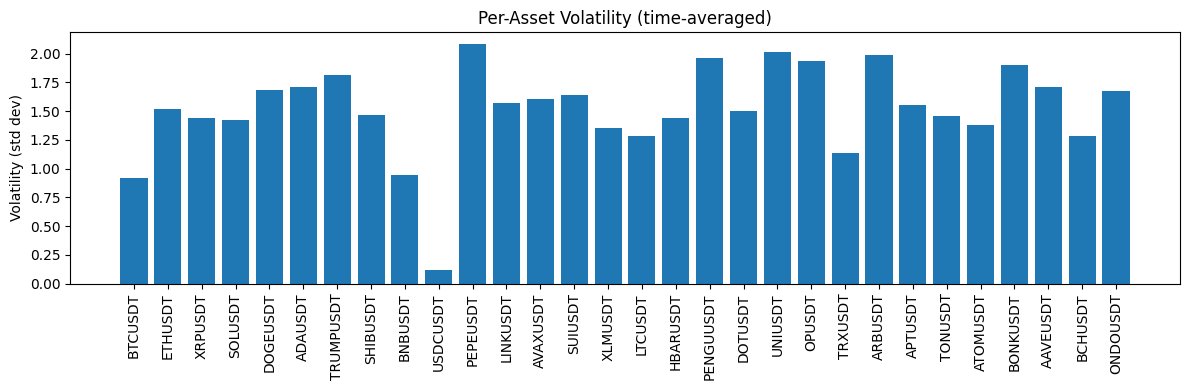

In [101]:
import numpy as np
import matplotlib.pyplot as plt

sigma_all = np.array(all_sigma).copy()
means = np.vstack(all_preds).copy()     # [T, S] (optional)
targets = np.vstack(all_targets).copy()  # [T, S] (optional)
predicted_vol = np.sqrt(all_sigma)
predicted_return = means.copy()

T, S = sigma_all.shape

asset_names = list_crypto.copy()

plt.figure(figsize=(12, 4))
idx = np.arange(S)
plt.bar(idx, predicted_vol.mean(axis=0) )
plt.xticks(idx, asset_names, rotation=90)
plt.ylabel("Volatility (std dev)")
plt.title("Per-Asset Volatility (time-averaged)")
plt.tight_layout()
plt.show()


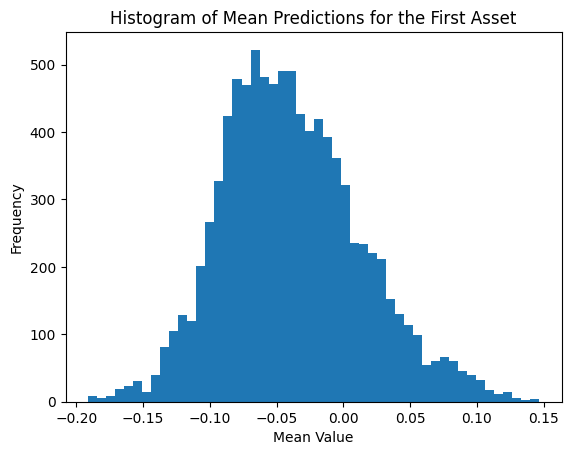

In [100]:
import matplotlib.pyplot as plt

plt.hist(means[:, 2], bins=50)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Predictions for the First Asset')
plt.show()


Creating Predicted Volatility and Predicted mean

In [102]:
sigma_all = np.array(all_sigma).copy()
means = np.vstack(all_preds).copy()     # [T, S] (optional)
targets = np.vstack(all_targets).copy()  # [T, S] (optional)
predicted_vol = np.sqrt(all_sigma)
predicted_return = means.copy()

Optimizer Functions

In [104]:
import numpy as np
import cvxpy as cp
from random import sample

def build_cov_matrix(std, corr):
    """Cov_ij = corr_ij * std_i * std_j"""
    return np.outer(std, std) * corr

def _solve_mvo_l1(mu, cov, gamma):
    """
    Maximize mu^T x - 0.5 * gamma * x^T cov x
    s.t. x = x+ - x-, x+>=0, x->=0, sum(x+ + x-) = 1   (=> ||x||_1 = 1)
    """
    n = len(mu)
    x_pos = cp.Variable(n, nonneg=True)
    x_neg = cp.Variable(n, nonneg=True)
    x = x_pos - x_neg

    obj = cp.Maximize(mu @ x - 0.5 * gamma * cp.quad_form(x, cov))
    cons = [cp.sum(x_pos + x_neg) == 1]  # exact L1 = 1
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.SCS)
    return x.value

def optimize_mvo(stats, gamma=3.0):
    mu, std, corr = stats['mean'], stats['std'], stats['corr']
    cov = build_cov_matrix(std, corr)
    return _solve_mvo_l1(mu, cov, gamma)

def optimize_method1(stats, gamma=3.0, theta=0.90):
    """
    1) Solve MVO under L1=1 to get eps (utility)
    2) Minimize ||x||_2^2 subject to utility >= theta * eps and L1=1 (via x = x+-x-)
    """
    mu, std, corr = stats['mean'], stats['std'], stats['corr']
    cov = build_cov_matrix(std, corr)
    n = len(mu)

    # --- Stage 1: baseline utility eps under L1=1
    w0 = _solve_mvo_l1(mu, cov, gamma)
    eps = float(mu @ w0 - 0.5 * gamma * (w0.T @ cov @ w0))

    # --- Stage 2: minimize ||x||_2^2 with same L1=1 and utility floor
    x_pos = cp.Variable(n, nonneg=True)
    x_neg = cp.Variable(n, nonneg=True)
    x = x_pos - x_neg

    util_constr = (mu @ x - 0.5 * gamma * cp.quad_form(x, cov)) >= theta * eps
    obj = cp.Minimize(cp.sum_squares(x))
    cons = [cp.sum(x_pos + x_neg) == 1, util_constr]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.SCS)
    return x.value

def _solve_mvo_sub_l1(mu_sub, cov_sub, gamma):
    m = len(mu_sub)
    x_pos = cp.Variable(m, nonneg=True)
    x_neg = cp.Variable(m, nonneg=True)
    x = x_pos - x_neg
    obj = cp.Maximize(mu_sub @ x - 0.5 * gamma * cp.quad_form(x, cov_sub))
    cons = [cp.sum(x_pos + x_neg) == 1]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.SCS)
    return x.value

def optimize_method2(stats, gamma=3.0, num_resamples=100, subset_size=5):
    mu, std, corr = stats['mean'], stats['std'], stats['corr']
    cov = build_cov_matrix(std, corr)
    n = len(mu)
    w_acc = np.zeros(n)

    for _ in range(num_resamples):
        subset = sorted(sample(range(n), subset_size))
        mu_sub  = mu[subset]
        cov_sub = cov[np.ix_(subset, subset)]
        try:
            w_sub = _solve_mvo_sub_l1(mu_sub, cov_sub, gamma)
        except Exception:
            continue
        w_full = np.zeros(n)
        for i, wi in zip(subset, w_sub):
            w_full[i] = wi
        w_acc += w_full

    return w_acc / max(1, num_resamples)


Creating dataset for test based on one step return

In [105]:
df_test = data.iloc[100:-100].copy()
df_test = df_test[df_test['day'].isin(list_days_test)]
df_test = df_test[['dateTime']+[x+'_'+'close' for x in list_crypto]]
df_test = df_test.set_index('dateTime')
df_test = 100*df_test.pct_change().shift(-1)
df_test = df_test.rename(columns={x:x.replace('close','return') for x in df_test.columns})
# df_test = df_test.iloc[my_seq_len:-shifted_window].copy()
df_test.iloc[0:0+my_seq_len]

,BTCUSDT_return,ETHUSDT_return,XRPUSDT_return,SOLUSDT_return,DOGEUSDT_return,ADAUSDT_return,TRUMPUSDT_return,SHIBUSDT_return,BNBUSDT_return,USDCUSDT_return,...,OPUSDT_return,TRXUSDT_return,ARBUSDT_return,APTUSDT_return,TONUSDT_return,ATOMUSDT_return,BONKUSDT_return,AAVEUSDT_return,BCHUSDT_return,ONDOUSDT_return
dateTime,,,,,,,,,,,,,,,,,,,,,
2025-07-23 00:00:00,-0.017172,-0.026474,0.056481,0.068239,-0.003713,-0.111062,-0.432199,0.000000,0.383560,0.010005,...,-0.212819,-0.028492,0.000000,-0.153925,0.129067,-0.137255,-0.162338,0.100337,-0.045703,-0.070597
2025-07-23 00:03:00,-0.062781,0.028353,-0.112899,-0.126644,-0.048270,-0.044474,0.072346,-0.064935,0.118930,-0.010004,...,-0.263455,0.009500,-0.124896,0.201879,0.128901,0.019635,-0.135501,-0.045268,-0.110499,-0.485694
2025-07-23 00:06:00,-0.028115,-0.044122,-0.155411,-0.160944,-0.148594,-0.033370,-0.009037,-0.064977,0.180711,0.000000,...,0.138365,0.155152,0.208420,0.012821,-0.233519,0.157048,-0.624152,-0.067933,0.133509,-0.106487
2025-07-23 00:09:00,-0.032629,-0.036918,0.019810,-0.161204,0.055806,-0.133526,-0.063263,-0.130039,0.409965,0.000000,...,0.087929,-0.148588,-0.083195,-0.148338,0.006002,-0.117601,-0.163845,-0.126246,-0.142854,-0.151017
2025-07-23 00:12:00,0.052007,0.090456,0.138645,0.161464,0.226816,0.222841,0.226081,0.260417,0.084171,-0.010005,...,0.263554,-0.025329,0.187344,0.256768,0.003001,0.372841,0.492341,0.187988,0.268951,0.213523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-23 03:45:00,-0.033285,-0.091556,0.091625,-0.014898,0.068221,0.022712,-0.063822,0.066007,0.370445,0.000000,...,0.000000,-0.211563,-0.063573,0.000000,0.024410,0.039596,-0.162426,-0.117582,-0.078174,-0.009082
2025-07-23 03:48:00,-0.030767,0.054126,0.008582,0.054634,0.121198,0.056767,0.072986,0.065963,-0.061513,0.000000,...,0.127616,0.034808,0.148431,0.072257,-0.042706,0.079161,0.027115,0.071940,0.499943,0.045413
2025-07-23 03:51:00,0.016948,-0.189340,0.005721,0.004964,0.034046,-0.034041,-0.072933,0.000000,-0.035172,0.010006,...,-0.012745,-0.006327,-0.063519,0.000000,-0.042725,-0.079098,-0.081323,-0.114368,-0.068353,-0.045393


Getting Weight for each timestamp based on predictions (3 methods)

In [106]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

alpha = 0.6
list_weight_m0 = []
list_weight_m1 = []
list_weight_m2 = []

# data_test_new = data_test.set_index('dateTime')
return_columns = [x for x in df_test.columns if ('return' in x and '_prev_return' not in x and len(x)>6)]
for i in range(0, len(df_test)-2*my_seq_len, shifted_window):
    end_time = df_test.index[i+my_seq_len-1]
    start_time = end_time - pd.Timedelta(minutes=4*60)
    past_returns_window = df_test.loc[start_time:end_time, return_columns]
    past_corr = past_returns_window.corr().to_numpy()
    past_mu  = past_returns_window.sum().to_numpy()
    past_vol = past_returns_window.std().to_numpy()
    past_vol[past_vol < 1e-8] = 1e-8

    weighted_mu  = (1 - alpha) * past_mu  + alpha * predicted_return[i]
    weighted_vol = (1 - alpha) * past_vol + alpha * predicted_vol[i]
    weighted_corr = (1) * past_corr

    stats = {
        "mean": weighted_mu,
        "std":  weighted_vol,
        "corr": past_corr
    }

    predicted_w_m0 = optimize_mvo(stats, gamma=3.0)
    predicted_w_m1 = optimize_method1(stats, gamma=3.0, theta=0.90)
    predicted_w_m2 = optimize_method2(
        stats,
        gamma=3.0,
        num_resamples=20,
        subset_size=5
    )

    list_weight_m0.append({'dateTime':df_test.index[i+my_seq_len]} | {list_crypto[ji]:predicted_w_m0[ji] for ji in range(len(list_crypto))})
    list_weight_m1.append({'dateTime':df_test.index[i+my_seq_len]} | {list_crypto[ji]:predicted_w_m1[ji] for ji in range(len(list_crypto))})
    list_weight_m2.append({'dateTime':df_test.index[i+my_seq_len]} | {list_crypto[ji]:predicted_w_m2[ji] for ji in range(len(list_crypto))})

    # break

In [107]:
df_weight0 = pd.DataFrame(list_weight_m0)
df_weight0 = df_weight0.set_index('dateTime')
df_weight1 = pd.DataFrame(list_weight_m1)
df_weight1 = df_weight1.set_index('dateTime')
df_weight2 = pd.DataFrame(list_weight_m2)
df_weight2 = df_weight2.set_index('dateTime')
df_weight0.sum(axis=0)

,0
BTCUSDT,2.610504e-01
ETHUSDT,1.211645e+00
XRPUSDT,1.193206e+00
SOLUSDT,-5.136893e-01
DOGEUSDT,-2.348614e+00
ADAUSDT,3.118240e-01
TRUMPUSDT,-1.459402e+00
SHIBUSDT,-5.012811e-01
BNBUSDT,1.451874e+00
USDCUSDT,-2.667596e-07


In [109]:
df_portfolio0 = df_test.iloc[80:].merge(df_weight0, left_index=True, right_index=True, how='left')
df_portfolio0 = df_portfolio0.fillna(method='ffill')
list_portfolio = []
for x in list_crypto:
  df_portfolio0[x+'_value'] = df_portfolio0[x+'_return']*df_portfolio0[x]
  list_portfolio.append(x+'_value')
df_portfolio1 = df_test.iloc[80:].merge(df_weight1, left_index=True, right_index=True, how='left')
df_portfolio1 = df_portfolio1.fillna(method='ffill')
for x in list_crypto:
  df_portfolio1[x+'_value'] = df_portfolio1[x+'_return']*df_portfolio1[x]
df_portfolio2 = df_test.iloc[80:].merge(df_weight2, left_index=True, right_index=True, how='left')
df_portfolio2 = df_portfolio2.fillna(method='ffill')
for x in list_crypto:
  df_portfolio2[x+'_value'] = df_portfolio2[x+'_return']*df_portfolio2[x]

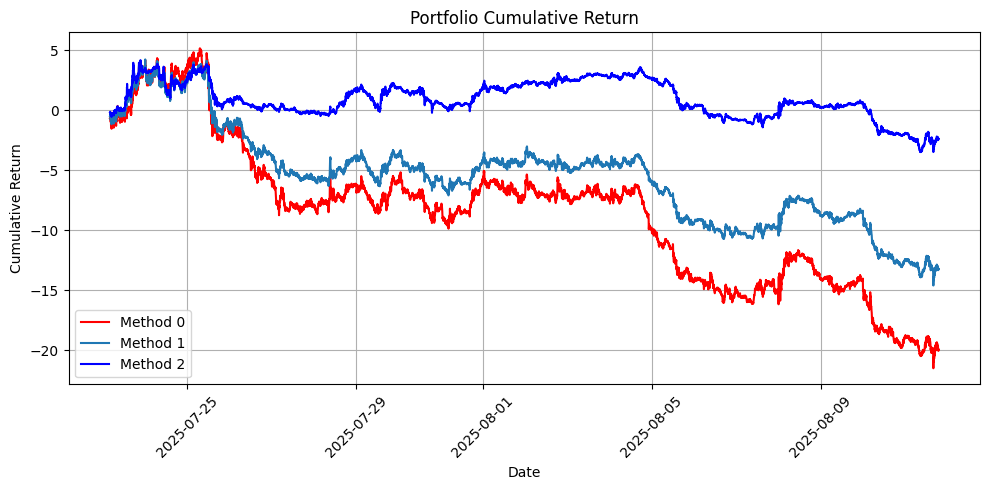

In [110]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio1['portfolio'] = df_portfolio1[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))

# Add labels here
plt.plot(df_portfolio0.index, df_portfolio0['portfolio'], color='red', label='Method 0')
plt.plot(df_portfolio1.index, df_portfolio1['portfolio'], label='Method 1')
plt.plot(df_portfolio2.index, df_portfolio2['portfolio'], color='blue', label='Method 2')

# Add legend
plt.legend(loc='best')

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Return')

plt.tight_layout()
plt.show()


In [111]:
df_portfolio0.to_csv('joint0.csv')

In [112]:
df_portfolio2.to_csv('joint2.csv')

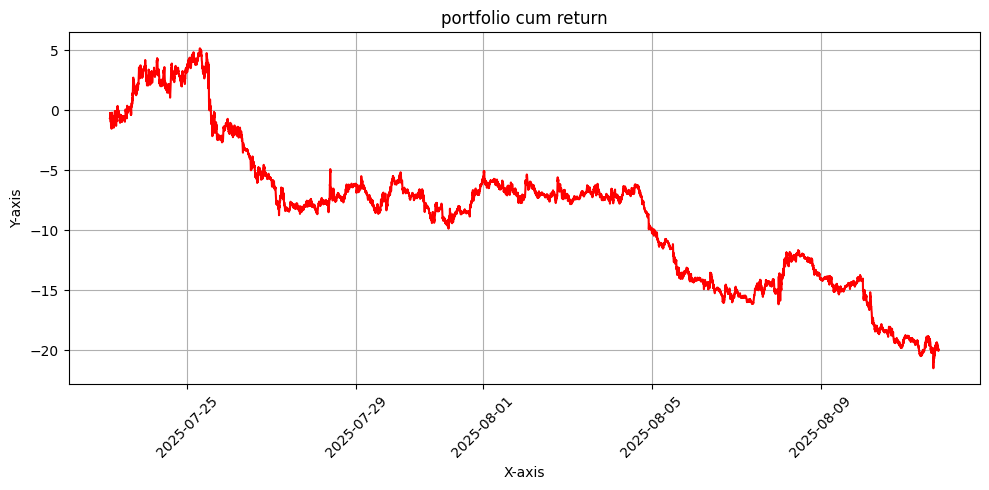

In [113]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(list(df_portfolio0.index), df_portfolio0['portfolio'].to_list(), color='red')  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()


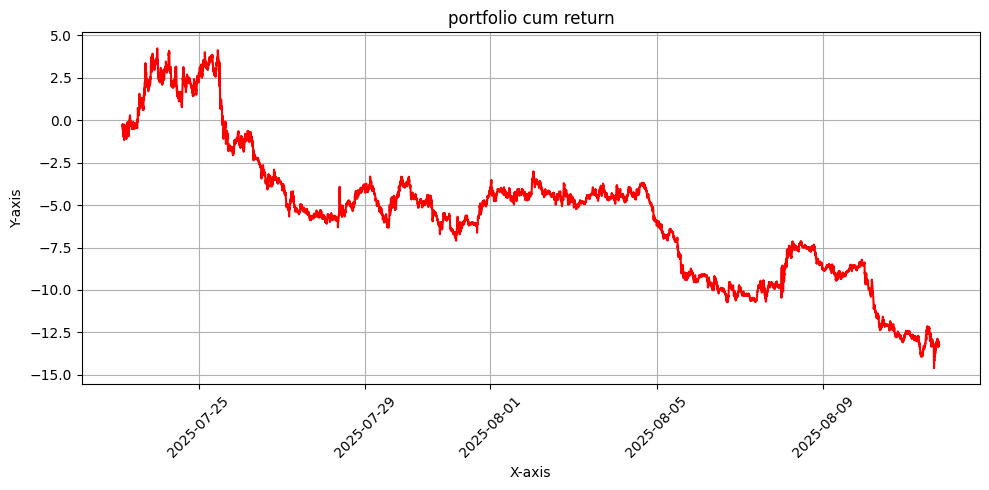

In [114]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(list(df_portfolio1.index), df_portfolio1['portfolio'].to_list(), color='red')  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()


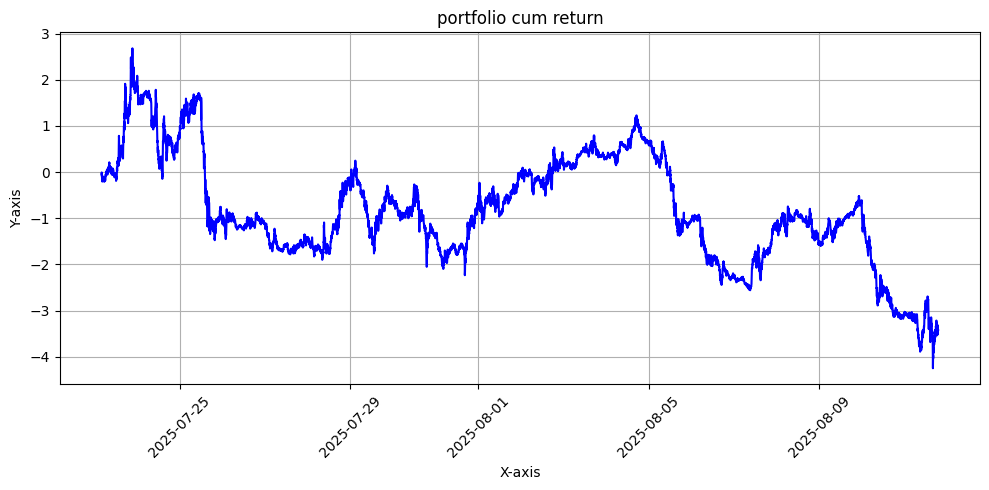

In [ ]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(list(df_portfolio2.index), df_portfolio2['portfolio'].to_list(), color='blue')  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()
